# Spatial Analysis of NBL data

Objectives:

1. Determine cell neighborhoods
2. cluster macrophages based on cell proximities
    - run differential experssion between clusters
3. look for subcellular gene expression at cell borders

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sci
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
# Import Scimap
import scimap as sm
# from kmodes.kmodes import KModes
import tqdm
from sklearn.cluster import KMeans
from statistics import mode

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Spatial TAM based clustering

In [7]:
# load data
adata = ad.read_h5ad('../03-clustering/Tiled_input/baysor_tiled_seg_withNoise.h5ad')
# adata = ad.read_h5ad('NBL_TAM_clustering.h5ad')
adata

AnnData object with n_obs × n_vars = 137671 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata.obs.leiden.unique()

['1', '2', '7', '0', '3', ..., '11', '10', '5', '13', '15']
Length: 16
Categories (16, object): ['0', '1', '2', '3', ..., '12', '13', '14', '15']

In [3]:
# only relevant for TAM clustering
adata.obs.index = list(map(float, adata.obs.index))
adata.obs.index = list(map(int, adata.obs.index))

In [4]:
# assigning cell labels
labels = pd.read_csv('../03-clustering/Tiled_input/outs/top_markers.csv', header=0, index_col=0)
label_dict = dict(zip(np.arange(15), labels.loc['CELL',:]))

In [5]:
adata.obs['cell_type'] = adata.obs.apply(lambda x: label_dict[int(x['leiden'])], axis=1)

In [11]:
adata.obs['cell_type2'].unique()

array(['Adrn_Cortex', 'Adrenergic', 'T_Cell', 'Fibroblast', 'NK_Cell',
       'Endothelial', 'Macrophage_TAM_2', 'Macrophage_TAM_1', 'B_Cell',
       'unknown'], dtype=object)

## Cell Neighborhoods and SCIMAP analysis

In [16]:
# adding new phenotyping for TAM clusters
adata.obs['cell_type2'] = adata.obs['cell_type'].astype(str).copy()

In [17]:
adata.obs['cell_type2'].loc[adata.obs['cell_type'] == "Macrophage_TAM"] = adata.obs.loc[adata.obs['cell_type'] == "Macrophage_TAM",:].apply(lambda x: x['cell_type'] + '_' + str(x['TAM_cluster']), axis=1)

/tmp/ipykernel_1510098/727909381.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
adata.obs['img_id'] = 1 # for scimap

In [20]:
# adata = sm.tl.spatial_distance(adata, x_coordinate='global_x', y_coordinate='global_y', 
#                                phenotype='cell_type', imageid='img_id')
# now with the TAM clusters
adata = sm.tl.spatial_distance(adata, x_coordinate='global_x', y_coordinate='global_y', 
                               phenotype='cell_type2', imageid='img_id')

Processing Image: 1


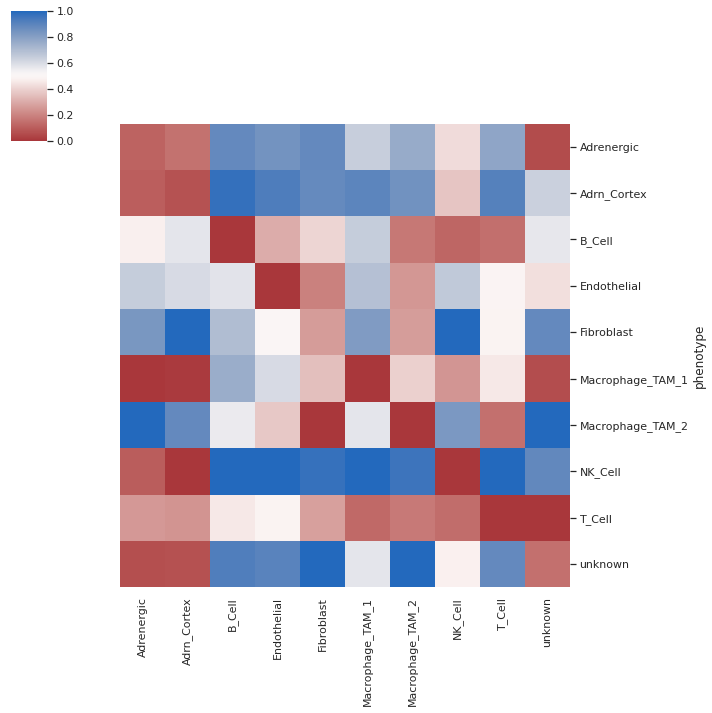

In [22]:
# sm.pl.spatial_distance(adata, phenotype='cell_type', heatmap_standard_scale=1)
sm.pl.spatial_distance(adata, phenotype='cell_type2', heatmap_standard_scale=1)
plt.savefig("outs/TAM-cluster_celltype_dist.png",  bbox_inches="tight")

In [19]:
# adata = sm.tl.spatial_interaction(adata, x_coordinate='global_x', y_coordinate='global_y', 
#                                phenotype='cell_type', imageid='img_id',
#                               method='knn')
adata = sm.tl.spatial_interaction(adata, x_coordinate='global_x', y_coordinate='global_y', 
                               phenotype='cell_type2', imageid='img_id',
                              method='radius', radius=30)

Processing Image: [1]
Identifying neighbours within 30 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


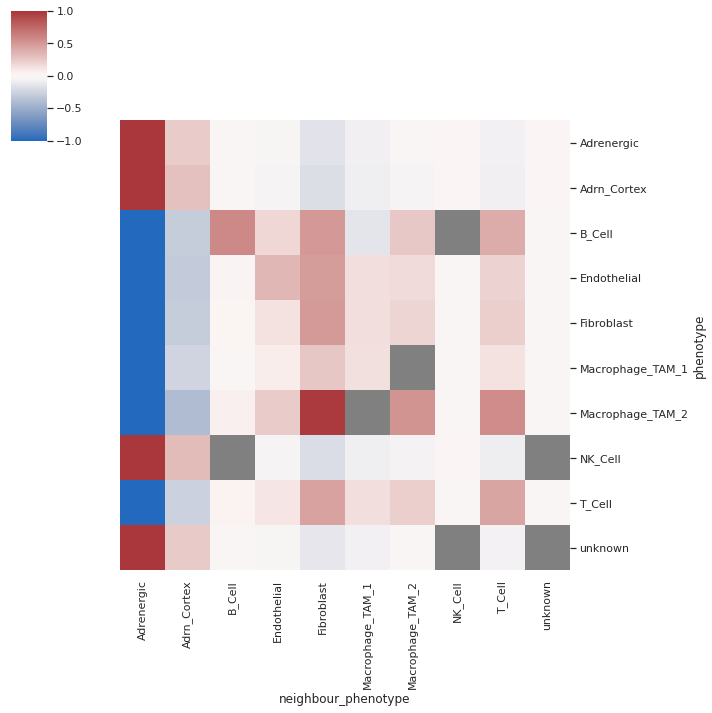

In [20]:
sm.pl.spatial_interaction(adata)
# plt.savefig("outs/TAM-cluster_celltype_itxn.png",  bbox_inches="tight")

In [32]:
# adata = sm.tl.spatial_lda(adata, num_motifs=6, radius=100, 
#                           imageid='img_id', x_coordinate='global_x', y_coordinate='global_y', 
#                           phenotype='cell_type')
adata = sm.tl.spatial_lda(adata, num_motifs=6, radius=100, 
                          imageid='img_id', x_coordinate='global_x', y_coordinate='global_y', 
                          phenotype='cell_type2')

Processing: [1]
Identifying neighbours within 100 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.3246230304345183
Gathering the latent weights


In [33]:
# assign motif to cells
m = adata.uns['spatial_lda'].columns
motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)

In [34]:
adata.obs['motif'] = motifs

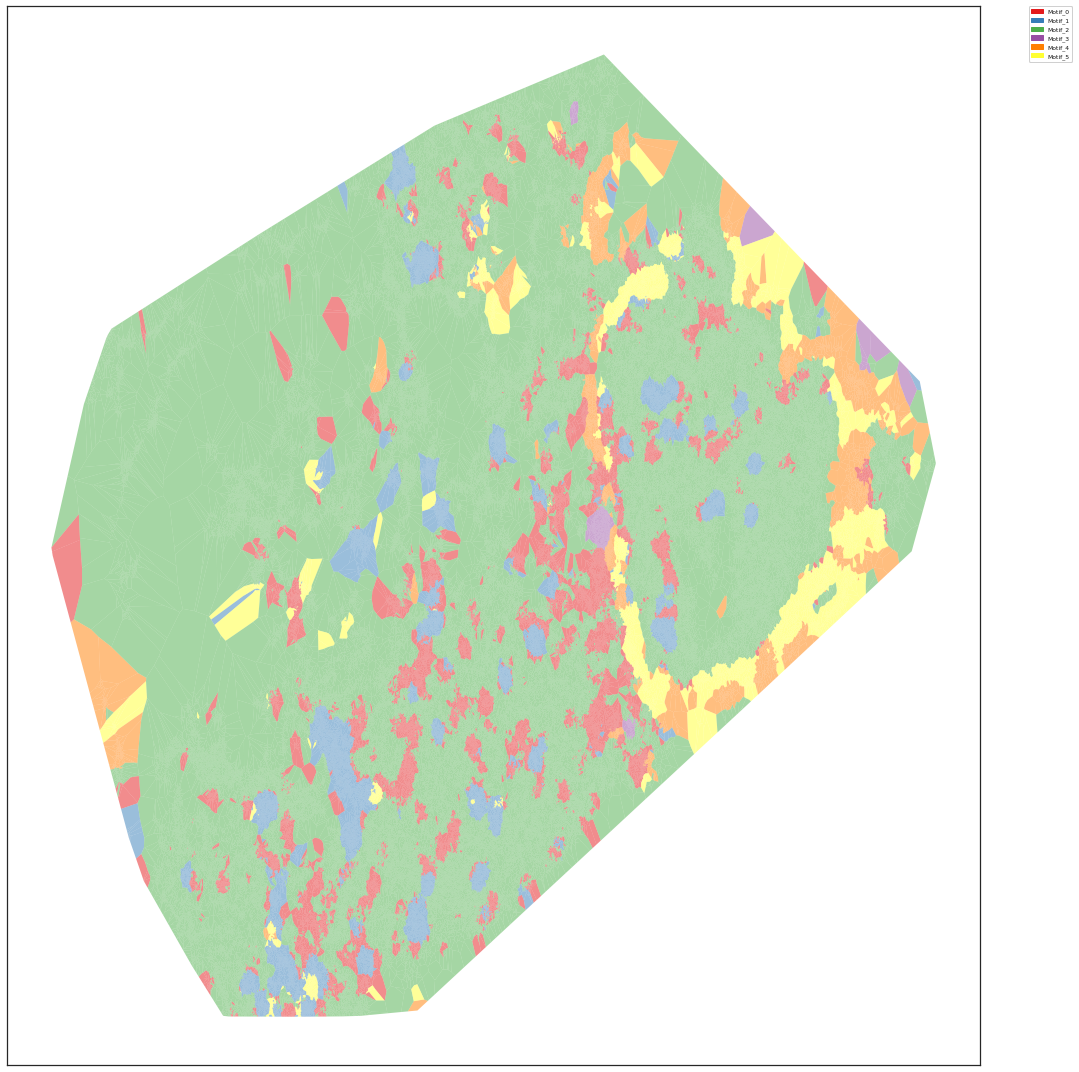

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
sm.pl.voronoi(adata, x_coordinate='global_x', y_coordinate='global_y', 
              color_by = 'motif', imageid='img_id', voronoi_edge_color='white', voronoi_line_width=0,
             **{'ax':ax})
plt.savefig("outs/voronoi_TAM-cluster_LDA_motifs.png")
plt.show()

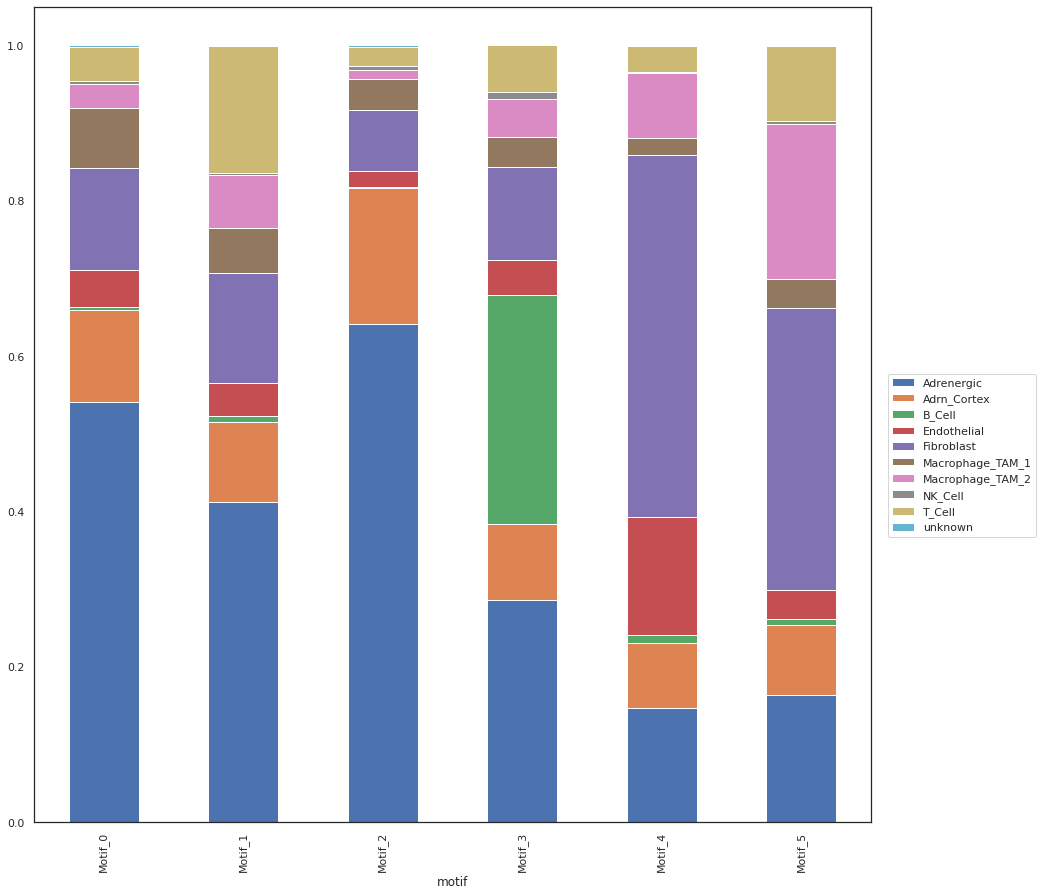

In [37]:
# comp = adata.obs[['cell_type','motif']].pivot_table(index='cell_type',columns='motif', 
#                                                       aggfunc=len, fill_value=0)
comp = adata.obs[['cell_type2','motif']].pivot_table(index='cell_type2',columns='motif', 
                                                      aggfunc=len, fill_value=0)
pdata = comp.apply(lambda x: x/x.sum(), axis=0)

fig, ax = plt.subplots(figsize=(15,15))
pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.savefig("outs/barplot_TAM-cluster_motif.png",  bbox_inches="tight")

# TAM triangulation and clustering

Clustering options:
1. convert indices to labels, to values; use k-means
2. kmodes clustering, https://pypi.org/project/kmodes/
    - This doesn't seem to work that well
3. Create distance matrix akin to hamming distance, create cluster from that

In [41]:
incentroids = adata.obs[['global_x','global_y']].to_numpy()
centroids.shape

(138131, 2)

In [42]:
tri = sci.spatial.Delaunay(centroids)
simpl = pd.DataFrame(tri.simplices)

In [35]:
print(tri.simplices.shape)

(276235, 3)


array([[ 81848,  79968,  75561],
       [ 79968,  75790,  75561],
       [  3796,    711, 130562],
       [ 71322,  71323,  71317],
       [ 71323,  71282,  71317],
       [ 71323,  71346,  71328]], dtype=int32)

In [43]:
TAM_index = simpl.apply(lambda x: any(adata.obs["cell_type"].iloc[x] == "Macrophage_TAM"), axis=1)
len(TAM_index)

276235

In [44]:
# add categorical label to simplices
TAM_simpl = simpl.loc[TAM_index,:]
# TAM_intxn = TAM_simpl.head().apply(lambda x: adata.obs["cell_type"].iloc[x], axis=1, result_type='broadcast')
TAM_intxn = TAM_simpl.applymap(lambda x: adata.obs["cell_type"].iloc[x])
TAM_intxn.tail()

,0,1,2
276230,Endothelial,Macrophage_TAM,Endothelial
276231,Macrophage_TAM,Endothelial,Adrn_Cortex
276232,Macrophage_TAM,Adrn_Cortex,Macrophage_TAM
276233,Endothelial,Macrophage_TAM,Macrophage_TAM
276234,Endothelial,Macrophage_TAM,Endothelial


## Trying kmodes

In [84]:
km = KModes(n_clusters=3, init='random', n_init=5, verbose=1)
clusters = km.fit_predict(TAM_intxn.to_numpy())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4650, cost: 69373.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15246, cost: 66857.0
Run 2, iteration: 2/100, moves: 9, cost: 66857.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 12463, cost: 70894.0
Run 3, iteration: 2/100, moves: 6407, cost: 70894.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15887, cost: 70009.0
Run 4, iteration: 2/100, moves: 2828, cost: 70009.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 12321, cost: 70367.0
Run 5, iteration: 2/100, moves: 111, cost: 70367.0
Best run was number 2


In [82]:
len(clusters)

53982

In [77]:
TAM_intxn['cluster'] = clusters

In [78]:
TAM_intxn_long = pd.melt(TAM_intxn, id_vars='cluster')
TAM_intxn_long.head()

,cluster,variable,value
0,2,0,Adrenergic
1,0,0,Macrophage_TAM
2,0,0,Macrophage_TAM
3,0,0,Macrophage_TAM
4,1,0,Adrenergic


In [79]:
comp = TAM_intxn_long[['cluster','value']].pivot_table(index='value',columns='cluster', 
                                                      aggfunc=len, fill_value=0)
pdata = comp.apply(lambda x: x/x.sum(), axis=0)

In [81]:
comp

cluster,0,1,2
value,,,
Adrenergic,16293,13455,14593
Adrn_Cortex,5361,4405,4704
B_Cell,355,278,257
Endothelial,1801,1572,1556
Fibroblast,9297,8190,7593
Macrophage_TAM,27138,19255,15859
NK_Cell,155,122,141
T_Cell,3435,3186,2842
unknown,32,39,32


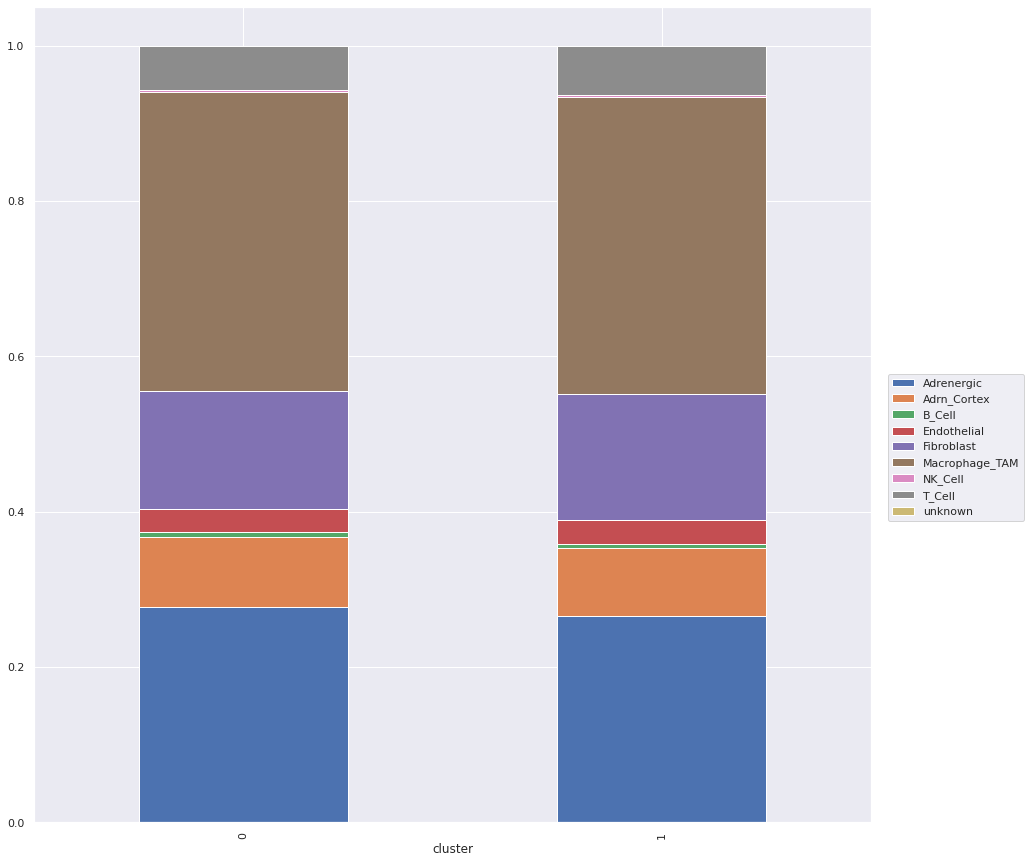

In [72]:
fig, ax = plt.subplots(figsize=(15,15))
pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

## Custom distance score

simplex-by-simplex measure the number of cells types that are different. 
Need to create a distance matrix. Maybe represent simplex with all cell categories (instead of points), then using more conventional clustering...like Kmodes...

- transformed the simplex to represent all cell types
- used k-means bc I thought k-modes wasn't working. K-modes probably works, but values need to represent categories and not be binary in long data form 

After, clustering, need to assign specific cells--not simplexes to the clusters...
- I can search the triangulation result by TAM point
- Or, for each simplex, assign the cluster to the adata meta


In [86]:
TAM_intxn.head()

,0,1,2
3,Adrenergic,Macrophage_TAM,Fibroblast
4,Macrophage_TAM,Macrophage_TAM,Fibroblast
5,Macrophage_TAM,Adrenergic,Fibroblast
6,Macrophage_TAM,Adrenergic,Adrenergic
8,Adrenergic,Adrenergic,Macrophage_TAM


In [38]:
cell_col_key = dict(zip(adata.obs['cell_type'].unique(), np.arange(adata.obs['cell_type'].nunique())))
cell_col_key

{'Adrn_Cortex': 0,
 'Adrenergic': 1,
 'T_Cell': 2,
 'Fibroblast': 3,
 'NK_Cell': 4,
 'Endothelial': 5,
 'Macrophage_TAM': 6,
 'B_Cell': 7,
 'unknown': 8}

In [39]:
def convert_simplex(x, x_key):
    r = pd.Series(np.zeros(9))
    for c in x:
        r.iloc[x_key[c]] = 1
    return r

In [40]:
simpl_dist_mat = TAM_intxn.apply(lambda x: convert_simplex(x, cell_col_key), axis=1)


NameError: name 'TAM_intxn' is not defined

In [118]:
# km = KModes(n_clusters=3, init='random', n_init=5, verbose=1)
# clusters = km.fit_predict(simpl_dist_mat.to_numpy())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12412, cost: 34693.0
Run 1, iteration: 2/100, moves: 8, cost: 34693.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6606, cost: 35573.0
Run 2, iteration: 2/100, moves: 1995, cost: 35573.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 34456.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 35125.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 6918, cost: 35573.0
Best run was number 3


In [119]:
# simpl_dist_mat['cluster'] = clusters
# TAM_intxn_long = pd.melt(simpl_dist_mat, id_vars='cluster')
# TAM_intxn_long.head()
# comp = TAM_intxn_long[['cluster','value']].pivot_table(index='value',columns='cluster', 
#                                                       aggfunc=len, fill_value=0)
# comp

cluster,0,1,2
value,,,
0.0,208779,90804,51422
1.0,82650,35322,16861


In [17]:
kmeans = KMeans(n_clusters=2, random_state=69).fit(simpl_dist_mat.to_numpy())

In [18]:
res = simpl_dist_mat.copy()
res['clusters'] = kmeans.labels_
res_long = pd.melt(res, id_vars='clusters')
res_long['value'] = res_long['value'] * res_long['variable']
comp = res_long[['clusters','value']].pivot_table(index='value',columns='clusters', 
                                                      aggfunc=len, fill_value=0)
comp.index = adata.obs['cell_type'].unique()
comp

clusters,0,1
Adrn_Cortex,215500,148775
Adrenergic,32381,0
T_Cell,2513,5982
Fibroblast,6918,14014
NK_Cell,188,228
Endothelial,1277,3154
Macrophage_TAM,32381,21601
B_Cell,210,613
unknown,61,42


### Incorporating clustering back into adata

unfortunately, find_simplex() only returns 1 simplex

for each simplex, sweep out the TAM index and assigned cluster into a dictionary.
bc each index will likely be in multiple simplices, and some simplices have multiple TAMs,
the final cluster assignment will be determined by vote...hopefully there'll be no ties

In [21]:
TAM_adata_index = np.where(adata.obs['cell_type']=='Macrophage_TAM')
TAM_adata_index[0:5]

(array([   290,    294,    300, ..., 137992, 137998, 138073]),)

In [79]:
# got the cluster assignments
TAM_dict = {k: [] for k in TAM_adata_index[0]}
for i in tqdm.tqdm(range(TAM_simpl.shape[0])):
    tam = [t for t in TAM_simpl.iloc[i] if t in TAM_adata_index[0]]
    for ti in tam:
        TAM_dict[ti].append(res['clusters'].iloc[i])

100%|██████████| 53982/53982 [00:07<00:00, 6899.88it/s]


In [88]:
# now to vote on the cluters
tam_cluster = []
for k, cl in TAM_dict.items():
    tam_cluster.append(mode(cl) + 1) # all the non-TAMs will be cluster 0

In [90]:
# now putting it into the MERSCOPE data
adata.obs['TAM_cluster'] = 0
adata.obs['TAM_cluster'].iloc[TAM_adata_index[0]] = tam_cluster

/tmp/ipykernel_2534164/2635947278.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
adata.obs['TAM_cluster'].value_counts()

0    127370
1      6402
2      4359
Name: TAM_cluster, dtype: int64

In [94]:
adata.write('NBL_TAM_clustering.h5ad')

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'cell_type' as categorical


## Differential expression testing on TAM macrophages!

,0,1,2,3,4,5,6,7,8,clusters
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
6,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
11,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [38]:
adata.obs.iloc[71323] #71323 has many simplices...do all return with find_simplex()?

cluster                           2
x                       31368.52952
y                      70434.302828
global_x                3387.803484
global_y                 7606.90986
n_genes                         103
n_genes_by_counts               103
total_counts                  440.0
leiden                            4
cell_type            Macrophage_TAM
Name: 102231, dtype: object

In [42]:
# 71323 in TAM_adata_index[0]
# multiple simplex:
# tri.find_simplex((3387.803484, 7606.90986))
# single simplex:
tri.find_simplex((919.722549, 5142.932294))

array(14995, dtype=int32)

In [31]:
TAM_test = TAM_adata_index[0][0:5]
TAM_center = adata.obs[['global_x', 'global_y']].iloc[TAM_test]
TAM_center

,global_x,global_y
306,919.722549,5142.932294
312,922.222055,5151.798054
318,919.277384,5159.619493
360,944.251548,5204.737913
366,952.615529,5204.886824


In [34]:
TAM_center.apply(lambda x: tri.find_simplex(x), axis=1)


306    14995
312    14993
318    14983
360    14991
366    14987
dtype: object

## Random stuff for a presentation

In [21]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'cell_type2' as categorical


In [23]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).to_csv("outs/global_mac_DEG.csv")

In [24]:
tam_data = adata[adata.obs['cell_type']=='Macrophage_TAM', :]

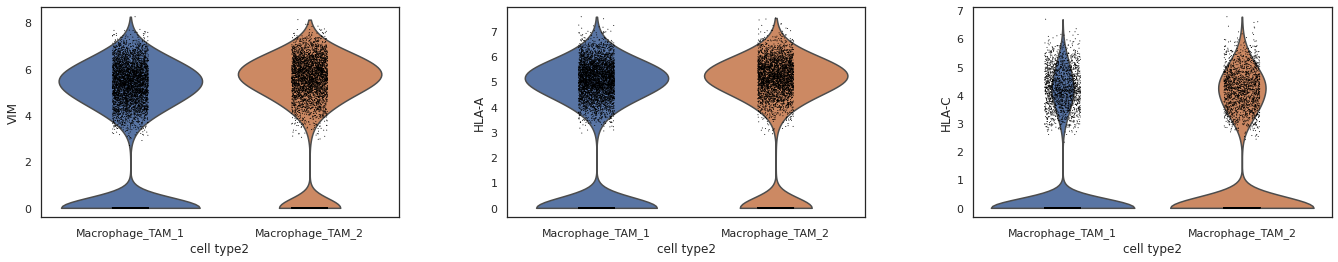

In [30]:
sc.pl.violin(tam_data, ['VIM', 'HLA-A', 'HLA-C'], groupby='cell_type2', use_raw=True, save='violin_TAM_cluster_down.png')

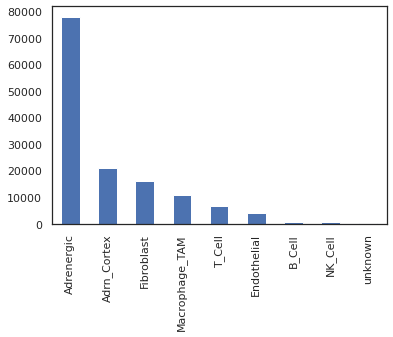

In [31]:
adata.obs.cell_type.value_counts().plot.bar()
plt.savefig('outs/cell_type_abundance.png', bbox_inches="tight")

In [32]:
adata

AnnData object with n_obs × n_vars = 138131 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster', 'cell_type2', 'img_id'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'spatial_interaction'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Adrenergic and Macrophage clustering based on scRNA-seq

In [17]:
adata = ad.read_h5ad('../03-clustering/Tiled_input/M0_A2_clustering_baysor_tiled_seg.h5ad')
adata

AnnData object with n_obs × n_vars = 138131 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster', 'cell_type_sub'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'cell_type_colors', 'cell_type_sub_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [18]:
adata.obs['img_id'] = 1 # for scimap

In [19]:
adata = sm.tl.spatial_distance(adata, x_coordinate='global_x', y_coordinate='global_y', 
                               phenotype='cell_type_sub', imageid='img_id')

Processing Image: 1


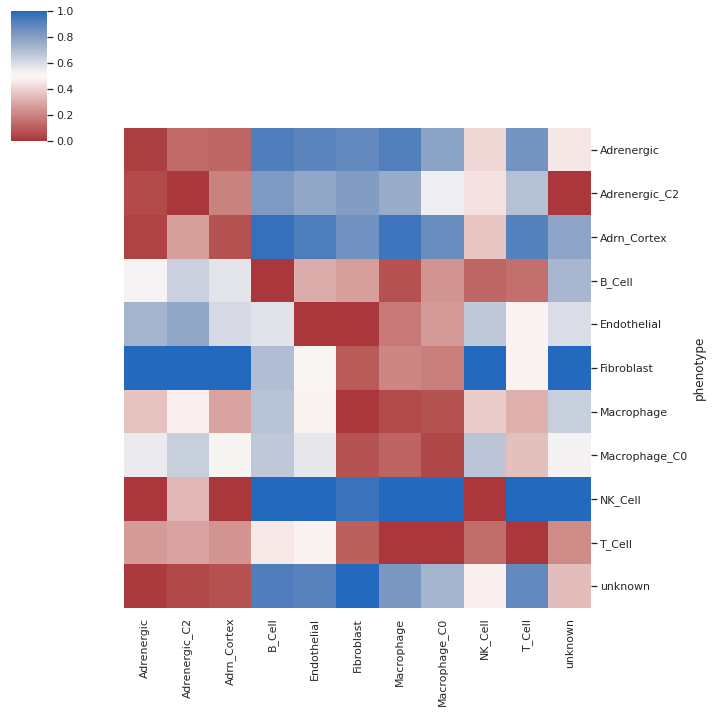

In [20]:
sm.pl.spatial_distance(adata, phenotype='cell_type_sub', heatmap_standard_scale=1)
plt.savefig("outs/M0_A2_subclustering/subcluster_celltype_dist.png",  bbox_inches="tight")

In [62]:
adata = sm.tl.spatial_interaction(adata, x_coordinate='global_x', y_coordinate='global_y', 
                               phenotype='cell_type_sub', imageid='img_id',
                              method='radius', radius=75)

Processing Image: [1]
Identifying neighbours within 75 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


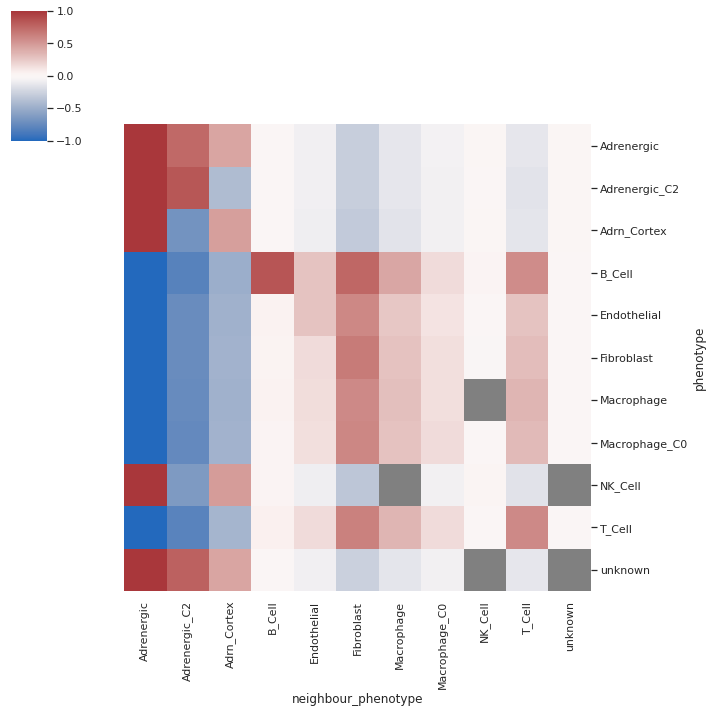

In [63]:
sm.pl.spatial_interaction(adata)
plt.savefig("outs/M0_A2_subclustering/subcluster_celltype_itxn_r75.png",  bbox_inches="tight")

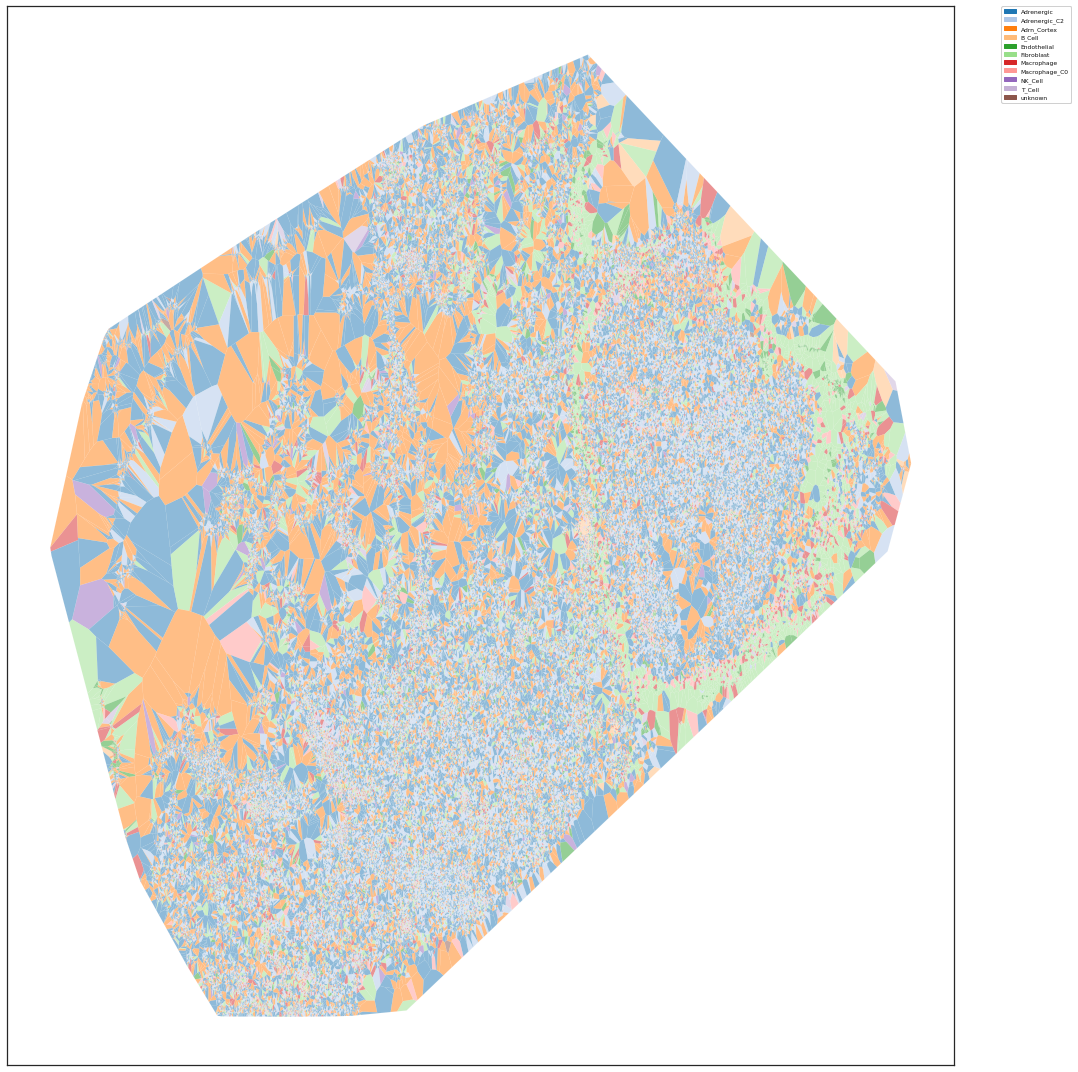

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
sm.pl.voronoi(adata, x_coordinate='global_x', y_coordinate='global_y', 
              color_by = 'cell_type_sub', imageid='img_id', voronoi_edge_color='white', voronoi_line_width=0.1,
             **{'ax':ax})
plt.savefig("outs/M0_A2_subclustering/voronoi_subcluster_celltype.pdf")
plt.show()

## C-C interaction

In [35]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import poisson
import math
import random

In [29]:
def single_csr(V, p, r):
    density = p/V
    probs = 2*(density*math.pi)*(r**2)*math.exp(-density*(r**2))
    return probs
make_csr = np.vectorize(single_csr)

In [30]:
def simulate_positions(ad, c1, c2):
    dat = ad[ad.obs['cell_type_sub'].isin([c1,c2]),:].copy()
    ymin = np.floor(dat.obs['global_y'].min()).astype(int)
    ymax = np.floor(dat.obs['global_y'].max()).astype(int)
    xmin = np.floor(dat.obs['global_x'].min()).astype(int)
    xmax = np.floor(dat.obs['global_x'].max()).astype(int)
    dat.obs['global_y'] = random.choices(range(ymin, ymax), k=dat.shape[0])
    dat.obs['global_x'] = random.choices(range(xmin, xmax), k=dat.shape[0])
    return dat

In [31]:
def cc_dist(ad, c1, c2):
    ref_dat = ad.obs.loc[ad.obs['cell_type_sub']==c1, ['global_y', 'global_x']]
    q_dat = ad.obs.loc[ad.obs['cell_type_sub']==c2, ['global_y', 'global_x']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    ecdf = ECDF(dist_res[0])
    return(ecdf)

In [32]:
# making the CSR
def simdata(adata, ref_dat, q_dat, ecdf):
    y = np.ptp(adata.obs['global_y'])
    x = np.ptp(adata.obs['global_x'])
    area = y*x
    events = ref_dat.shape[0] + q_dat.shape[0]
    dist = np.arange(1,np.floor(ecdf.x.max()), 5)
    csr_prob = make_csr(area, events, dist)
    csr_prob = csr_prob/csr_prob.sum()
    csr_cdf = np.array(list(map(lambda x: csr_prob[0:x].sum(), np.arange(len(dist)))))
    return (dist, csr_cdf)

In [59]:
cc = 'Macrophage'
c = 'Adrenergic'

In [60]:
ref_dat = adata.obs.loc[adata.obs['cell_type_sub']==c, ['global_y', 'global_x']]
q_dat = adata.obs.loc[adata.obs['cell_type_sub']==cc, ['global_y', 'global_x']]
ref_tree = sci.spatial.cKDTree(ref_dat)
dist_res = ref_tree.query(q_dat, k=1)
ecdf = ECDF(dist_res[0])
csr_dat = simdata(adata, ref_dat, q_dat, ecdf)

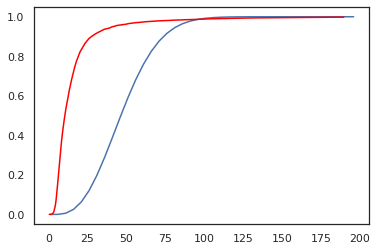

In [61]:
plt.plot(csr_dat[0][csr_dat[0]<200], csr_dat[1][csr_dat[0]<200])
plt.plot(ecdf.x[ecdf.x < 200], ecdf.y[ecdf.x < 200], c='red')
plt.savefig('outs/M0_A2_subclustering/Adrenergic-Macrophage_dist_cdf.png')